# Tutorial for the montecarlo python package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Loading and using the package

To load, make sure you are in the top directory and do

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import model

# For Jupyter notebooks only:
%matplotlib inline

## Run photon packets in parallel plane medium

This is an example code to run a Monte Carlo calculation for photon packets travelling in a scattering medium.

Set random number seed.  This is so that the code produces the same trajectories each time (for testing purposes).  Comment this out or set the seed to `None` for real calculations.

In [2]:
seed = 1

In [3]:
# Properties of system
ntrajectories = 100                     # number of trajectories
nevents = 100                           # number of scattering events in each trajectory
wavelen = sc.Quantity('600 nm')
radius = sc.Quantity('0.125 um')
volume_fraction = sc.Quantity(0.5, '')
n_particle = sc.Quantity(1.54, '')      # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelen)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelen)      # space within sample. n_medium is outside the sample.
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction)

In [4]:
#%%timeit
# Calculate the phase function and scattering and absorption coefficients from the single scattering model
# (this absorption coefficient is of the scatterer, not of an absorber added to the system)
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen, 
                                  phase_mie=False, mu_scat_mie=False)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, incidence_angle = 0.)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

## Plot trajectories

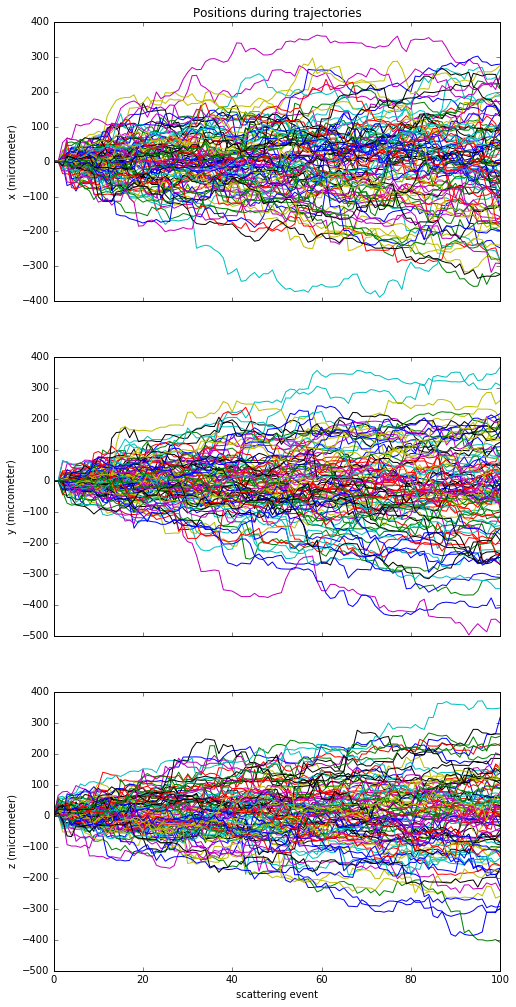

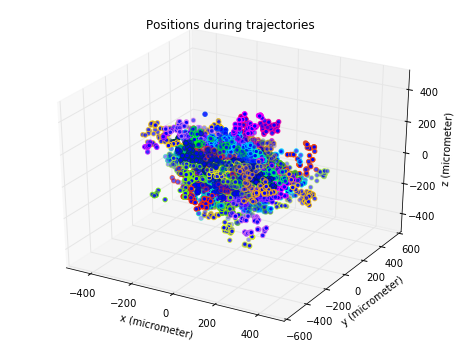

In [5]:
trajectories.plot_coord(ntrajectories, three_dim=True)

## Calculate the fraction of trajectories that are reflected and transmitted

In [6]:
z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('50 um')

R_fraction, T_fraction = mc.calc_refl_trans(trajectories, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(R_fraction))
print('T = '+ str(T_fraction))
print('Absorption coefficient = ' + str(mu_abs))

R = 0.720002025385
T = 0.279997974615
Absorption coefficient = 2.2233688704468595e-16 1 / micrometer


## Add an absorber to the system

In [7]:
# Choose some absorption coefficient corresponding to some absorber
mu_abs_dye = sc.Quantity(0.01,'1/um')

# Create new trajectories object
trajectories_dye = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories_dye.absorb(mu_abs_dye, step)                         
trajectories_dye.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories_dye.move(step)
R_fraction, T_fraction = mc.calc_refl_trans(trajectories_dye, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(R_fraction))
print('T = '+ str(T_fraction))
print('Absorption coefficient = ' + str(mu_abs_dye))

R = 0.364436314788
T = 0.0877363115451
Absorption coefficient = 0.01 1 / micrometer


The reflected fraction decreases with the addition of an absorber as expected. 

## Calculate the fraction of reflected and transmitted trajectories using core-shell particles

Running the model using core-shell particles, where the shell is assumed to be index matched with the matrix, is similar to running the model using particles without shells. The difference is that there are extra parameters that need to be specified in the case of the core-shells. 

In [8]:
# Properties of system
ntrajectories = 100                     
nevents = 100                           
wavelen = sc.Quantity('600 nm')

# Specify the radius of the core and the radius of the core + shell
core_radius = sc.Quantity('0.115 um')
shell_radius = sc.Quantity('0.125 um')

# Specify the volume fraction of just the cores. If unknown: 
# volume_fraction_core = volume_fraction * (core_radius / shell_radius)**3
# where volume_fraction is the volume fraction of the entire core-shell particle
volume_fraction_core = sc.Quantity(0.39, '')    

# Specify the refractive indices
n_particle = sc.Quantity(1.54, '')     
n_matrix = ri.n('vacuum', wavelen)     
n_medium = ri.n('vacuum', wavelen)      
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction_core)   # use the volume fraction of the core

# Calculate the phase function and scattering and absorption coefficients. Note the addition of shell_radius to the
# input parameters
p, mu_scat, mu_abs = mc.calc_scat(core_radius, n_particle, n_sample, volume_fraction_core, wavelen, 
                                  shell_radius = shell_radius, phase_mie=False, mu_scat_mie=False)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, incidence_angle = 0.)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

# Calculate the fraction of reflected and transmitted trajectories
z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('50 um')

R_fraction, T_fraction = mc.calc_refl_trans(trajectories, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(R_fraction))
print('T = '+ str(T_fraction))
print('Absorption coefficient = ' + str(mu_abs))

R = 0.716628533103
T = 0.283371466897
Absorption coefficient = 2.227114992074554e-16 1 / micrometer


# Run photon packets in a medium with a spherical boundary

This is an example code to run a Monte Carlo calculation for photon packets travelling in material with a spherical boundary

##### Set system parameters and initialize the trajectories for a sphere

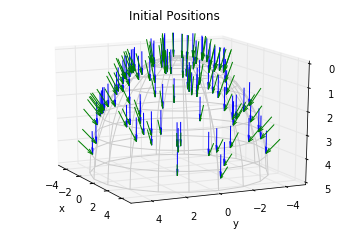

In [8]:
# Properties of system
ntrajectories = 100                     # number of trajectories
nevents = 100                           # number of scattering events in each trajectory
wavelen = sc.Quantity('600 nm')
radius = sc.Quantity('0.125 um')
assembly_radius = sc.Quantity('5 um')
volume_fraction = sc.Quantity(0.5, '')
n_particle = sc.Quantity(1.54, '')      # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelen)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelen)      # space within sample. n_medium is outside the sample.
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction)

#%%timeit
# Calculate the phase function and scattering and absorption coefficients from the single scattering model
# (this absorption coefficient is of the scatterer, not of an absorber added to the system)
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen, 
                                  phase_mie=False, mu_scat_mie=False)

# Initialize the trajectories for a sphere
# set plot_initial to True to see the initial positions of trajectories. The default value of plot_initial is False
r0, k0, W0 = mc.initialize_sphere(nevents, ntrajectories, n_medium, n_sample, 
                                  assembly_radius, plot_initial = True)


##### Set up trajectories object and run the photons
this part is exactly the same as in the film case

In [9]:
# make positions, directions, and weights into quantities with units
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

##### Calculate reflectance and transmittance excluding fresnel reflected trajectories

R = 0.32267150181
T = 0.67732849819
Absorption coefficient = 2.2233688704468595e-16 1 / micrometer


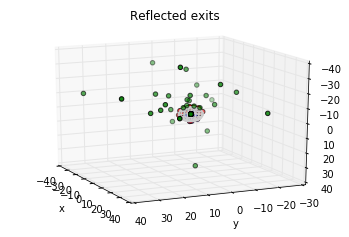

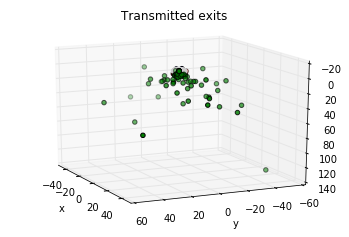

In [19]:
# Calculate reflectance and transmittance
# Set plot_exits to true to plot positions of trajectories just before (red) and after (green) exit.
# The default value of plot_exits is False.
# Set tir = True to rerun trajectory weight that are fresnel reflected back into the sphere upon exit.
# The default value of tir is False. 
R_fraction, T_fraction = mc.calc_refl_trans_sphere(trajectories, n_medium, n_sample, assembly_radius, 
                                                   p, mu_abs, mu_scat, plot_exits = True, tir=False)

print('R = '+ str(R_fraction))
print('T = '+ str(T_fraction))
print('Absorption coefficient = ' + str(mu_abs))

# ignore runtime warning 
import warnings
warnings.filterwarnings("ignore")

##### Calculate reflectance and transmittance including fresnel reflected trajectories

In [21]:
# Calculate reflectance and transmittance
# Set plot_exits to true to plot positions of trajectories just before (red) and after (green) exit.
# The default value of plot_exits is False.
# Set tir = True to rerun trajectory weight that are fresnel reflected back into the sphere upon exit.
# The default value of tir is False.
R_fraction_tir, T_fraction_tir = mc.calc_refl_trans_sphere(trajectories, n_medium, n_sample, assembly_radius, 
                                                   p, mu_abs, mu_scat, tir=True)

print('R = '+ str(R_fraction_tir))
print('T = '+ str(T_fraction_tir))
print('Absorption coefficient = ' + str(mu_abs))

R = 0.261004571492
T = 0.738995428508
Absorption coefficient = 2.2233688704468595e-16 1 / micrometer
